Author: Daniel Lusk, University of Potsdam

Inspired by: Ankit Kariryaa ([github repo](https://github.com/ankitkariryaa/An-unexpectedly-large-count-of-trees-in-the-western-Sahara-and-Sahel))

In [2]:
import glob
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from functools import reduce
from tqdm import tqdm_notebook as tqdm

from config import UNetTraining
from core.dataset_generator import DataGenerator
from core.frame_info import FrameInfo
from core.split_frames import split_dataset
from core.UNet import UNet
from core.visualize import display_images

warnings.filterwarnings("ignore")  # ignore annoying warnings

# Magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

2023-02-01 07:38:12.493152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 07:38:18.933606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load the configuration and get the image directories.

In [11]:
config = UNetTraining.Config()
im_dirs = glob.glob(os.path.join(config.image_dir, "*"))

Read all images (aka frames) into memory

In [5]:
frames = []

for d in tqdm(im_dirs):
    rgbi_im = rio.open(glob.glob(os.path.join(d, config.rgbi_dn, "*.tif"))[0])
    ndvi_im = rio.open(glob.glob(os.path.join(d, config.ndvi_dn, "*.tif"))[0])
    label_im = rio.open(glob.glob(os.path.join(d, config.label_dn, "*.tif"))[0])
    weights_im = rio.open(glob.glob(os.path.join(d, config.weights_dn, "*.tif"))[0])
    
    read_rgbi_im = (np.moveaxis(rgbi_im.read(), 0, -1)) / 255  # Scale to 0-1
    read_ndvi_im = (np.moveaxis(ndvi_im.read(), 0, -1) + 1) / 2  # Scale to 0-1
    read_label_im = np.moveaxis(label_im.read(), 0, -1)
    read_weights_im = np.moveaxis(weights_im.read(), 0, -1)
    
    if config.use_binary_labels:
        read_label_im[read_label_im > 0] = 1 # Binarize labels
    
    comb_im = np.dstack((read_rgbi_im, read_ndvi_im))
    f = FrameInfo(comb_im, read_label_im, read_weights_im, d)
    frames.append(f)

  0%|          | 0/360 [00:00<?, ?it/s]

Split into train, validation, and test sets, and initialize generators for each set.

In [6]:
train_frame_idx, val_frame_idx, test_frame_idx = split_dataset(
    frames, config.frames_json, config.patch_dir
)

# Sanity check for set sizes
print("Training set size:", len(train_frame_idx))
print("Validation set size:", len(val_frame_idx))
print("Testing set size:", len(test_frame_idx))

annotation_channels = config.input_label_channel + config.input_weight_channel

# Training data generator
# Don't apply augmentation for now until the weighting scheme overwriting is figured out.
train_generator = DataGenerator(
    config.input_image_channels,
    config.patch_size,
    train_frame_idx,
    frames,
    annotation_channels,
).random_generator(config.BATCH_SIZE)

# Validation data generator
val_generator = DataGenerator(
    config.input_image_channels,
    config.patch_size,
    val_frame_idx,
    frames,
    annotation_channels
).random_generator(config.BATCH_SIZE)

# Testing data generator
test_generator = DataGenerator(
    config.input_image_channels,
    config.patch_size,
    test_frame_idx,
    frames,
    annotation_channels
).random_generator(config.BATCH_SIZE)

Reading train-test split from file...
Training set size: 230
Validation set size: 58
Testing set size: 72


Inspect the images to ensure their labels and weights correspond accurately

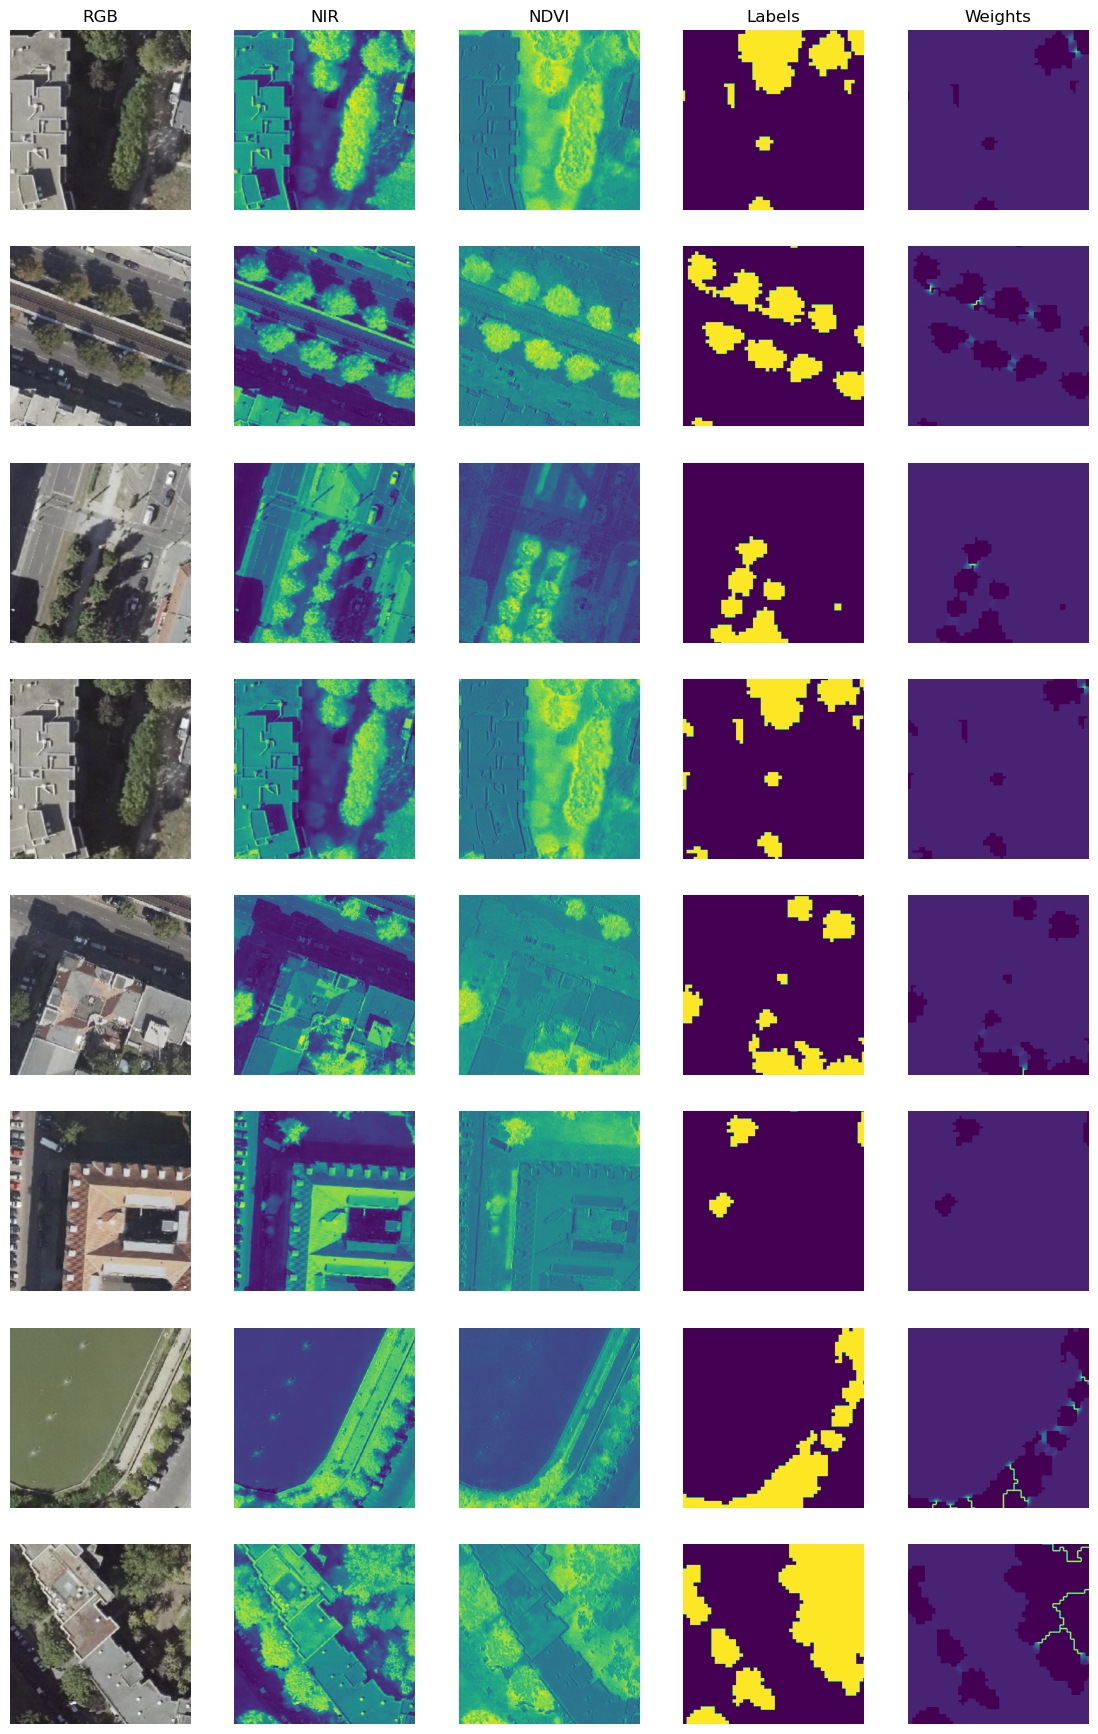

In [7]:
titles = ["RGB", "NIR", "NDVI", "Labels", "Weights"]

train_images, real_label = next(train_generator)
display_images(np.concatenate((train_images, real_label), axis=-1), config.input_image_channels, annotation_channels, titles)

Configure the model by defining optimizer and loss functions, as well as where to save it.

In [8]:
timestamp = time.strftime("%Y%m%d-%H%M")
channels = config.input_image_channels
channels = reduce(lambda a, b: a + str(b), channels, "")

if config.weights_only:
    if not os.path.exists(config.weights_path):
        os.makedirs(config.weights_path)

    weights_path = os.path.join(
        config.weights_path,
        f"{timestamp}_{config.OPTIMIZER_NAME}_{config.LOSS_NAME}_{channels}_{config.input_shape[0]}.hdf5"
    )
else:
    if not os.path.exists(config.model_path):
        os.makedirs(config.model_path)

    model_path = os.path.join(
        config.model_path,
        f"{timestamp}_{config.OPTIMIZER_NAME}_{config.LOSS_NAME}_{channels}_{config.input_shape[0]}.h5"
    )


Define the model and compile it

In [9]:
model = UNet([config.BATCH_SIZE, *config.input_shape], config.input_label_channel)
model.compile(optimizer=config.optimizer, loss=config.loss, metrics=config.metrics)

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2944        ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

Train the model

In [12]:
loss_history = [
    model.fit(
        train_generator,
        steps_per_epoch=config.MAX_TRAIN_STEPS,
        epochs=config.EPOCHS,
        validation_data=val_generator,
        validation_steps=config.VAL_LIMIT,
        callbacks=config.callbacks,
        workers=1
    )
]

Epoch 1/50


TypeError: 'NoneType' object is not callable